walmart 주단위 데이터 139주로 향후 4주 예측하기

In [42]:
import tensorflow as tf
import numpy as np
import matplotlib
import os
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime  
# tf.set_random_seed(77)
columns=['date','sales']
txs=pd.read_table('./lstmData/lstmPrac11.csv', sep=',',header=None,names=columns )
tf.reset_default_graph()

In [43]:
txs

,date,sales
0,2010-02-05,24924.50
1,2010-02-12,46039.49
2,2010-02-19,41595.55
3,2010-02-26,19403.54
4,2010-03-05,21827.90
5,2010-03-12,21043.39
6,2010-03-19,22136.64
7,2010-03-26,26229.21
8,2010-04-02,57258.43
9,2010-04-09,42960.91


In [44]:
def noOutlierSales(sales):
    mean=np.mean(sales)
    std=np.std(sales)
    for i in range(len(sales)):
        if (sales[i]<mean-2*std or sales[i]>mean+2*std):
             sales[i]=int(mean)
    return sales
def logSales(sales):
    for i in range(len(sales)):
        if sales[i] is 0:
            sales[i]=1
    return np.log(sales)
def sqrtSales(sales):
    return np.sqrt(sales)


def rmse(a,b):
    sum=0
    for i in range(len(a)):
        sum=sum+(a[i]-b[i])**2
    return np.sqrt(sum/len(a))

def minMaxNormalizer(data):
    numerator=data-np.min(data)
    denominator=np.max(data)-np.min(data)
    return numerator/(denominator+1e-7)

def minMaxDeNormalizer(data, originalData):
    shift=np.min(originalData)
    multiplier=np.max(originalData)-np.min(originalData)
    return (data+shift)*multiplier


In [45]:
def LSTM(txs, forecastDay, features):

    #Add basic date related features to the table
    year = lambda x: datetime.strptime(x, "%Y-%m-%d").year
    dayOfWeek = lambda x: datetime.strptime(x, "%Y-%m-%d").weekday()
    month = lambda x: datetime.strptime(x, "%Y-%m-%d").month
    weekNumber = lambda x: datetime.strptime(x, "%Y-%m-%d").strftime('%V')
    txs['year'] = txs['date'].map(year)
    txs['month'] = txs['date'].map(month)
    txs['weekNumber'] = txs['date'].map(weekNumber)
    txs['dayOfWeek'] = txs['date'].map(dayOfWeek)

    #Add non-basic date related features to the table
    seasons = [0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 0]  # dec - feb is winter, then spring, summer, fall etc
    season = lambda x: seasons[(datetime.strptime(x, "%Y-%m-%d").month - 1)]
    day_of_week01s = [0, 0, 0, 0, 0, 1, 1]
    day_of_week01 = lambda x: day_of_week01s[(datetime.strptime(x, "%Y-%m-%d").weekday())]
    txs['season'] = txs['date'].map(season)
    txs['dayOfWeek01'] = txs['date'].map(day_of_week01)

    #Backup originalSales
    originalSales = list(txs['sales'])
    sales = list(txs['sales'])

    if features is 'DayOfWeek_WeekNumber_Month_Season' :
        tempxy = [list(txs['dayOfWeek']), list(txs['weekNumber']),list(txs['month']),list(txs['season']) , sales]
    elif features is'DayOfWeek01_WeekNumber_Month_Season' :
        tempxy = [list(txs['dayOfWeek01']), list(txs['weekNumber']),list(txs['month']),list(txs['season']) , sales]

    elif features is 'WeekNumber_Month_Season_Year' :
        tempxy = [list(txs['weekNumber']), list(txs['month']), list(txs['season']),list(txs['year']), sales]

    xy = np.array(tempxy).transpose().astype(np.float)

    #Backup originalXY for denormalize
    originalXY = np.array(tempxy).transpose().astype(np.float)
    xy = minMaxNormalizer(xy)

    #TRAIN PARAMETERS
    # data_dim은 y값 도출을 위한 feature 가지수+1(독립변수 가지수 +1(y포함))
    data_dim = 5
    # data_dim크기의 data 한 묶음이 seq_length만큼 input으로 들어가
    seq_length = 5
    # output_dim(=forecastDays)만큼의 다음날 y_data를 예측
    output_dim = forecastDay
    # hidden_dim은 정말 임의로 설정
    hidden_dim = 50
    # learning rate은 배우는 속도(너무 크지도, 작지도 않게 설정)
    learning_rate = 0.001
    # iterations는 반복 횟수
    iterations = 5000

    # Build a series dataset(seq_length에 해당하는 전날 X와 다음 forecastDays에 해당하는 Y)
    x = xy
    y = xy[:, [-1]]
    dataX = []
    dataY = []
    for i in range(0, len(y) - seq_length - forecastDay+1):
        _x = x[i:i + seq_length]
        _y = y[i + seq_length:i + seq_length + forecastDay]
        _y = np.reshape(_y, (forecastDay))
        print(_x,"->",_y)
        dataX.append(_x)
        dataY.append(_y)
    print('data set length:',len(y) - seq_length - forecastDay+1)
    
    train_size = int(len(dataY) * 0.7)
    test_size = len(dataY) - train_size
    print('train size:' , train_size)
    print('test size:' , test_size)
    trainX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:])
    print('trainX:', trainX)
    print('testX:', testX)
    trainY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:])

    X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
    Y = tf.placeholder(tf.float32, [None, forecastDay])

    cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
    outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
    Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn=None)
    loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train = optimizer.minimize(loss)
    
    denormalizedTestY=originalSales[train_size+seq_length:]
#     denormalizedTestY_feed=np.array([[i] for i in denormalizedTestY])
    
    targets = tf.placeholder(tf.float32, [None, 1])
    predictions = tf.placeholder(tf.float32, [None, 1])
 
    with tf.Session() as sess:

        # 초기화
        init = tf.global_variables_initializer()
        sess.run(init)

        # Training step
        for i in range(iterations):
            _, step_loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
            print("[step: {}] loss: {}".format(i, step_loss))
       

        # Test step
        # test_predict= sess.run(Y_pred, feed_dict={X: testX}
        test_predict = minMaxDeNormalizer(sess.run(Y_pred, feed_dict={X: testX}),originalXY)
        realSale= minMaxDeNormalizer(testY,originalXY)
        # Plot predictions
#         plt.plot(denormalizedTestY_feed) #실제 sales 파란색
#         plt.plot(realSale)      #실제 sales 파란색
        plt.plot(test_predict) #예측 sales 주황색
               
        plt.xlabel("Time Period")
        plt.ylabel("Stock Price")
        plt.show()
        
    return (test_predict), realSale




[[  8.68174327e-05   3.47269731e-05   0.00000000e+00   3.49006079e-02
    4.32776220e-01]
 [  1.04180919e-04   3.47269731e-05   0.00000000e+00   3.49006079e-02
    7.99406065e-01]
 [  1.21544406e-04   3.47269731e-05   0.00000000e+00   3.49006079e-02
    7.22243772e-01]
 [  1.38907892e-04   3.47269731e-05   0.00000000e+00   3.49006079e-02
    3.36913105e-01]
 [  1.56271379e-04   5.20904596e-05   1.73634865e-05   3.49006079e-02
    3.79008448e-01]] -> [ 0.36538662]
[[  1.04180919e-04   3.47269731e-05   0.00000000e+00   3.49006079e-02
    7.99406065e-01]
 [  1.21544406e-04   3.47269731e-05   0.00000000e+00   3.49006079e-02
    7.22243772e-01]
 [  1.38907892e-04   3.47269731e-05   0.00000000e+00   3.49006079e-02
    3.36913105e-01]
 [  1.56271379e-04   5.20904596e-05   1.73634865e-05   3.49006079e-02
    3.79008448e-01]
 [  1.73634865e-04   5.20904596e-05   1.73634865e-05   3.49006079e-02
    3.65386619e-01]] -> [ 0.38436925]
[[  1.21544406e-04   3.47269731e-05   0.00000000e+00   3.4900607

    6.70941268e-01]] -> [ 0.59450633]
[[  6.94539461e-04   1.73634865e-04   5.20904596e-05   3.49006079e-02
    4.06097744e-01]
 [  7.11902948e-04   1.73634865e-04   5.20904596e-05   3.49006079e-02
    4.68438043e-01]
 [  7.29266434e-04   1.73634865e-04   5.20904596e-05   3.49006079e-02
    4.43516231e-01]
 [  7.46629921e-04   1.73634865e-04   5.20904596e-05   3.49006079e-02
    6.70941268e-01]
 [  7.63993407e-04   1.90998352e-04   5.20904596e-05   3.49006079e-02
    5.94506332e-01]] -> [ 0.33944557]
[[  7.11902948e-04   1.73634865e-04   5.20904596e-05   3.49006079e-02
    4.68438043e-01]
 [  7.29266434e-04   1.73634865e-04   5.20904596e-05   3.49006079e-02
    4.43516231e-01]
 [  7.46629921e-04   1.73634865e-04   5.20904596e-05   3.49006079e-02
    6.70941268e-01]
 [  7.63993407e-04   1.90998352e-04   5.20904596e-05   3.49006079e-02
    5.94506332e-01]
 [  7.81356894e-04   1.90998352e-04   5.20904596e-05   3.49006079e-02
    3.39445570e-01]] -> [ 0.33950547]
[[  7.29266434e-04   1.736

[step: 28] loss: 3.456716537475586
[step: 29] loss: 3.454197883605957
[step: 30] loss: 3.4196557998657227
[step: 31] loss: 3.360903263092041
[step: 32] loss: 3.287217140197754
[step: 33] loss: 3.2076659202575684
[step: 34] loss: 3.1299774646759033
[step: 35] loss: 3.059938430786133
[step: 36] loss: 3.0012316703796387
[step: 37] loss: 2.95558500289917
[step: 38] loss: 2.9231035709381104
[step: 39] loss: 2.9026927947998047
[step: 40] loss: 2.8924760818481445
[step: 41] loss: 2.89017391204834
[step: 42] loss: 2.893409252166748
[step: 43] loss: 2.8999338150024414
[step: 44] loss: 2.9077773094177246
[step: 45] loss: 2.915335178375244
[step: 46] loss: 2.9214043617248535
[step: 47] loss: 2.9251790046691895
[step: 48] loss: 2.926223039627075
[step: 49] loss: 2.9244213104248047
[step: 50] loss: 2.9199259281158447
[step: 51] loss: 2.9130935668945312
[step: 52] loss: 2.904423236846924
[step: 53] loss: 2.8944969177246094
[step: 54] loss: 2.8839223384857178
[step: 55] loss: 2.8732855319976807
[step

[step: 280] loss: 2.289350986480713
[step: 281] loss: 2.286348342895508
[step: 282] loss: 2.2833428382873535
[step: 283] loss: 2.2803354263305664
[step: 284] loss: 2.2773265838623047
[step: 285] loss: 2.2743163108825684
[step: 286] loss: 2.271306037902832
[step: 287] loss: 2.2682957649230957
[step: 288] loss: 2.2652854919433594
[step: 289] loss: 2.2622766494750977
[step: 290] loss: 2.2592697143554688
[step: 291] loss: 2.256265163421631
[step: 292] loss: 2.253262996673584
[step: 293] loss: 2.250265121459961
[step: 294] loss: 2.2472705841064453
[step: 295] loss: 2.24428129196167
[step: 296] loss: 2.2412967681884766
[step: 297] loss: 2.2383179664611816
[step: 298] loss: 2.2353458404541016
[step: 299] loss: 2.2323803901672363
[step: 300] loss: 2.2294225692749023
[step: 301] loss: 2.2264723777770996
[step: 302] loss: 2.2235310077667236
[step: 303] loss: 2.2205986976623535
[step: 304] loss: 2.2176756858825684
[step: 305] loss: 2.2147622108459473
[step: 306] loss: 2.2118592262268066
[step: 30

[step: 503] loss: 1.6806039810180664
[step: 504] loss: 1.6789472103118896
[step: 505] loss: 1.6773152351379395
[step: 506] loss: 1.6757091283798218
[step: 507] loss: 1.6741290092468262
[step: 508] loss: 1.6725739240646362
[step: 509] loss: 1.6710444688796997
[step: 510] loss: 1.6695406436920166
[step: 511] loss: 1.6680619716644287
[step: 512] loss: 1.6666083335876465
[step: 513] loss: 1.6651791334152222
[step: 514] loss: 1.6637747287750244
[step: 515] loss: 1.662394642829895
[step: 516] loss: 1.6610386371612549
[step: 517] loss: 1.6597058773040771
[step: 518] loss: 1.6583961248397827
[step: 519] loss: 1.657109022140503
[step: 520] loss: 1.6558449268341064
[step: 521] loss: 1.6546014547348022
[step: 522] loss: 1.6533799171447754
[step: 523] loss: 1.6521786451339722
[step: 524] loss: 1.6509976387023926
[step: 525] loss: 1.6498360633850098
[step: 526] loss: 1.6486932039260864
[step: 527] loss: 1.647569179534912
[step: 528] loss: 1.6464625597000122
[step: 529] loss: 1.6453731060028076
[ste

[step: 726] loss: 1.4174376726150513
[step: 727] loss: 1.415691614151001
[step: 728] loss: 1.413956880569458
[step: 729] loss: 1.4122815132141113
[step: 730] loss: 1.4108034372329712
[step: 731] loss: 1.4099016189575195
[step: 732] loss: 1.4098515510559082
[step: 733] loss: 1.4099128246307373
[step: 734] loss: 1.4067940711975098
[step: 735] loss: 1.4020700454711914
[step: 736] loss: 1.4007110595703125
[step: 737] loss: 1.401014804840088
[step: 738] loss: 1.3982787132263184
[step: 739] loss: 1.3949060440063477
[step: 740] loss: 1.3944447040557861
[step: 741] loss: 1.3932632207870483
[step: 742] loss: 1.3900192975997925
[step: 743] loss: 1.3885204792022705
[step: 744] loss: 1.3877116441726685
[step: 745] loss: 1.3850510120391846
[step: 746] loss: 1.3830058574676514
[step: 747] loss: 1.3820655345916748
[step: 748] loss: 1.379883885383606
[step: 749] loss: 1.3776352405548096
[step: 750] loss: 1.3764303922653198
[step: 751] loss: 1.3745533227920532
[step: 752] loss: 1.372278094291687
[step:

[step: 958] loss: 0.9527233242988586
[step: 959] loss: 0.9514130353927612
[step: 960] loss: 0.9501715302467346
[step: 961] loss: 0.9490633010864258
[step: 962] loss: 0.9481696486473083
[step: 963] loss: 0.9476224184036255
[step: 964] loss: 0.9474292397499084
[step: 965] loss: 0.9473075270652771
[step: 966] loss: 0.946334719657898
[step: 967] loss: 0.9437573552131653
[step: 968] loss: 0.9402550458908081
[step: 969] loss: 0.9377907514572144
[step: 970] loss: 0.9371656179428101
[step: 971] loss: 0.9372320175170898
[step: 972] loss: 0.9363466501235962
[step: 973] loss: 0.9340647459030151
[step: 974] loss: 0.9316485524177551
[step: 975] loss: 0.9303560256958008
[step: 976] loss: 0.9299294948577881
[step: 977] loss: 0.9291821718215942
[step: 978] loss: 0.9274991750717163
[step: 979] loss: 0.9254999160766602
[step: 980] loss: 0.9240767359733582
[step: 981] loss: 0.9232934713363647
[step: 982] loss: 0.9224787950515747
[step: 983] loss: 0.9211249351501465
[step: 984] loss: 0.9194462895393372
[s

[step: 1193] loss: 0.7416762113571167
[step: 1194] loss: 0.7413373589515686
[step: 1195] loss: 0.7410008907318115
[step: 1196] loss: 0.7406646609306335
[step: 1197] loss: 0.7403303980827332
[step: 1198] loss: 0.7399981021881104
[step: 1199] loss: 0.7396664619445801
[step: 1200] loss: 0.7393362522125244
[step: 1201] loss: 0.7390071153640747
[step: 1202] loss: 0.7386781573295593
[step: 1203] loss: 0.7383503317832947
[step: 1204] loss: 0.7380235195159912
[step: 1205] loss: 0.737697958946228
[step: 1206] loss: 0.7373761534690857
[step: 1207] loss: 0.737057089805603
[step: 1208] loss: 0.7367479801177979
[step: 1209] loss: 0.7364542484283447
[step: 1210] loss: 0.736194908618927
[step: 1211] loss: 0.7360062003135681
[step: 1212] loss: 0.7359730005264282
[step: 1213] loss: 0.7362819910049438
[step: 1214] loss: 0.7373072504997253
[step: 1215] loss: 0.7397899627685547
[step: 1216] loss: 0.7443736791610718
[step: 1217] loss: 0.7505396604537964
[step: 1218] loss: 0.7534111738204956
[step: 1219] lo

[step: 1436] loss: 0.672731339931488
[step: 1437] loss: 0.6724864840507507
[step: 1438] loss: 0.6722416877746582
[step: 1439] loss: 0.6719974875450134
[step: 1440] loss: 0.6717526912689209
[step: 1441] loss: 0.6715080738067627
[step: 1442] loss: 0.6712632775306702
[step: 1443] loss: 0.6710196137428284
[step: 1444] loss: 0.6707764863967896
[step: 1445] loss: 0.670533299446106
[step: 1446] loss: 0.6702896952629089
[step: 1447] loss: 0.6700466871261597
[step: 1448] loss: 0.6698040962219238
[step: 1449] loss: 0.6695616245269775
[step: 1450] loss: 0.6693195104598999
[step: 1451] loss: 0.6690776348114014
[step: 1452] loss: 0.6688356399536133
[step: 1453] loss: 0.6685936450958252
[step: 1454] loss: 0.6683522462844849
[step: 1455] loss: 0.6681112051010132
[step: 1456] loss: 0.6678699254989624
[step: 1457] loss: 0.6676291227340698
[step: 1458] loss: 0.6673880815505981
[step: 1459] loss: 0.667147159576416
[step: 1460] loss: 0.6669074296951294
[step: 1461] loss: 0.6666672229766846
[step: 1462] lo

[step: 1664] loss: 0.618114173412323
[step: 1665] loss: 0.617843508720398
[step: 1666] loss: 0.6175721883773804
[step: 1667] loss: 0.6173000335693359
[step: 1668] loss: 0.6170268654823303
[step: 1669] loss: 0.6167535185813904
[step: 1670] loss: 0.6164788007736206
[step: 1671] loss: 0.6162031888961792
[step: 1672] loss: 0.6159278154373169
[step: 1673] loss: 0.6156502366065979
[step: 1674] loss: 0.6153731346130371
[step: 1675] loss: 0.615094006061554
[step: 1676] loss: 0.6148146986961365
[step: 1677] loss: 0.6145342588424683
[step: 1678] loss: 0.6142536401748657
[step: 1679] loss: 0.613971471786499
[step: 1680] loss: 0.6136882305145264
[step: 1681] loss: 0.6134049892425537
[step: 1682] loss: 0.6131199598312378
[step: 1683] loss: 0.6128346920013428
[step: 1684] loss: 0.6125482320785522
[step: 1685] loss: 0.6122608184814453
[step: 1686] loss: 0.6119725108146667
[step: 1687] loss: 0.6116830110549927
[step: 1688] loss: 0.6113928556442261
[step: 1689] loss: 0.6111027002334595
[step: 1690] los

[step: 1907] loss: 0.5090505480766296
[step: 1908] loss: 0.508340060710907
[step: 1909] loss: 0.5076262354850769
[step: 1910] loss: 0.5069105625152588
[step: 1911] loss: 0.5061922073364258
[step: 1912] loss: 0.5054718255996704
[step: 1913] loss: 0.504747748374939
[step: 1914] loss: 0.5040209889411926
[step: 1915] loss: 0.5032916069030762
[step: 1916] loss: 0.5025599002838135
[step: 1917] loss: 0.5018253326416016
[step: 1918] loss: 0.5010887384414673
[step: 1919] loss: 0.5003486275672913
[step: 1920] loss: 0.4996058940887451
[step: 1921] loss: 0.4988608658313751
[step: 1922] loss: 0.49811261892318726
[step: 1923] loss: 0.4973630905151367
[step: 1924] loss: 0.49660950899124146
[step: 1925] loss: 0.49585413932800293
[step: 1926] loss: 0.49509570002555847
[step: 1927] loss: 0.4943341910839081
[step: 1928] loss: 0.4935709238052368
[step: 1929] loss: 0.49280428886413574
[step: 1930] loss: 0.49203598499298096
[step: 1931] loss: 0.4912645220756531
[step: 1932] loss: 0.49049049615859985
[step: 

[step: 2129] loss: 0.3320741653442383
[step: 2130] loss: 0.32737278938293457
[step: 2131] loss: 0.3248581886291504
[step: 2132] loss: 0.325431764125824
[step: 2133] loss: 0.32760417461395264
[step: 2134] loss: 0.32904940843582153
[step: 2135] loss: 0.328183114528656
[step: 2136] loss: 0.3257169723510742
[step: 2137] loss: 0.3235265016555786
[step: 2138] loss: 0.3231009244918823
[step: 2139] loss: 0.3240784704685211
[step: 2140] loss: 0.3249535858631134
[step: 2141] loss: 0.3246327340602875
[step: 2142] loss: 0.3232154846191406
[step: 2143] loss: 0.32186219096183777
[step: 2144] loss: 0.3214489817619324
[step: 2145] loss: 0.32184433937072754
[step: 2146] loss: 0.32224103808403015
[step: 2147] loss: 0.3219754993915558
[step: 2148] loss: 0.32112520933151245
[step: 2149] loss: 0.32025647163391113
[step: 2150] loss: 0.3198741674423218
[step: 2151] loss: 0.31994861364364624
[step: 2152] loss: 0.3200658857822418
[step: 2153] loss: 0.3198692798614502
[step: 2154] loss: 0.31933051347732544
[ste

[step: 2367] loss: 0.2719283103942871
[step: 2368] loss: 0.2718147039413452
[step: 2369] loss: 0.27167463302612305
[step: 2370] loss: 0.271471232175827
[step: 2371] loss: 0.2712228298187256
[step: 2372] loss: 0.27098485827445984
[step: 2373] loss: 0.27079230546951294
[step: 2374] loss: 0.2706364393234253
[step: 2375] loss: 0.2704851031303406
[step: 2376] loss: 0.2703114449977875
[step: 2377] loss: 0.270109087228775
[step: 2378] loss: 0.2698909044265747
[step: 2379] loss: 0.269681453704834
[step: 2380] loss: 0.26949259638786316
[step: 2381] loss: 0.26931947469711304
[step: 2382] loss: 0.2691519856452942
[step: 2383] loss: 0.2689768075942993
[step: 2384] loss: 0.2687894105911255
[step: 2385] loss: 0.2685920000076294
[step: 2386] loss: 0.2683927118778229
[step: 2387] loss: 0.2681981027126312
[step: 2388] loss: 0.26801061630249023
[step: 2389] loss: 0.267830491065979
[step: 2390] loss: 0.26765239238739014
[step: 2391] loss: 0.2674739956855774
[step: 2392] loss: 0.26729243993759155
[step: 2

[step: 2580] loss: 0.2369678020477295
[step: 2581] loss: 0.23679739236831665
[step: 2582] loss: 0.23662233352661133
[step: 2583] loss: 0.23644976317882538
[step: 2584] loss: 0.2362852543592453
[step: 2585] loss: 0.2361292988061905
[step: 2586] loss: 0.23598140478134155
[step: 2587] loss: 0.23584002256393433
[step: 2588] loss: 0.235702782869339
[step: 2589] loss: 0.2355654239654541
[step: 2590] loss: 0.2354293167591095
[step: 2591] loss: 0.23529204726219177
[step: 2592] loss: 0.23515450954437256
[step: 2593] loss: 0.23501697182655334
[step: 2594] loss: 0.2348783016204834
[step: 2595] loss: 0.23474177718162537
[step: 2596] loss: 0.23460733890533447
[step: 2597] loss: 0.23447749018669128
[step: 2598] loss: 0.23435421288013458
[step: 2599] loss: 0.23424120247364044
[step: 2600] loss: 0.23414331674575806
[step: 2601] loss: 0.23406989872455597
[step: 2602] loss: 0.23403142392635345
[step: 2603] loss: 0.23405325412750244
[step: 2604] loss: 0.2341606318950653
[step: 2605] loss: 0.2344221323728

[step: 2816] loss: 0.21469059586524963
[step: 2817] loss: 0.2127014547586441
[step: 2818] loss: 0.2065628170967102
[step: 2819] loss: 0.20545434951782227
[step: 2820] loss: 0.2092979997396469
[step: 2821] loss: 0.2106563150882721
[step: 2822] loss: 0.20711810886859894
[step: 2823] loss: 0.20446047186851501
[step: 2824] loss: 0.20599156618118286
[step: 2825] loss: 0.20801006257534027
[step: 2826] loss: 0.20685537159442902
[step: 2827] loss: 0.20434218645095825
[step: 2828] loss: 0.20413726568222046
[step: 2829] loss: 0.20566098392009735
[step: 2830] loss: 0.20592495799064636
[step: 2831] loss: 0.20442655682563782
[step: 2832] loss: 0.20330557227134705
[step: 2833] loss: 0.20380271971225739
[step: 2834] loss: 0.2045784294605255
[step: 2835] loss: 0.20413058996200562
[step: 2836] loss: 0.2030409872531891
[step: 2837] loss: 0.20271143317222595
[step: 2838] loss: 0.20317983627319336
[step: 2839] loss: 0.20338773727416992
[step: 2840] loss: 0.20283320546150208
[step: 2841] loss: 0.2021869271

[step: 3053] loss: 0.17114385962486267
[step: 3054] loss: 0.17098194360733032
[step: 3055] loss: 0.17081871628761292
[step: 3056] loss: 0.1706530749797821
[step: 3057] loss: 0.17048753798007965
[step: 3058] loss: 0.17032337188720703
[step: 3059] loss: 0.1701599657535553
[step: 3060] loss: 0.16999545693397522
[step: 3061] loss: 0.16982921957969666
[step: 3062] loss: 0.169662207365036
[step: 3063] loss: 0.1694970279932022
[step: 3064] loss: 0.16933171451091766
[step: 3065] loss: 0.16916555166244507
[step: 3066] loss: 0.16899915039539337
[step: 3067] loss: 0.16883191466331482
[step: 3068] loss: 0.16866426169872284
[step: 3069] loss: 0.16849657893180847
[step: 3070] loss: 0.16832950711250305
[step: 3071] loss: 0.1681618094444275
[step: 3072] loss: 0.16799357533454895
[step: 3073] loss: 0.16782483458518982
[step: 3074] loss: 0.16765588521957397
[step: 3075] loss: 0.16748690605163574
[step: 3076] loss: 0.1673177182674408
[step: 3077] loss: 0.1671489030122757
[step: 3078] loss: 0.166978806257

[step: 3286] loss: 0.13258594274520874
[step: 3287] loss: 0.13242843747138977
[step: 3288] loss: 0.1322711706161499
[step: 3289] loss: 0.13211411237716675
[step: 3290] loss: 0.1319573074579239
[step: 3291] loss: 0.13180038332939148
[step: 3292] loss: 0.13164393603801727
[step: 3293] loss: 0.13148756325244904
[step: 3294] loss: 0.13133138418197632
[step: 3295] loss: 0.13117516040802002
[step: 3296] loss: 0.13101977109909058
[step: 3297] loss: 0.13086356222629547
[step: 3298] loss: 0.13070820271968842
[step: 3299] loss: 0.1305527687072754
[step: 3300] loss: 0.13039812445640564
[step: 3301] loss: 0.13024333119392395
[step: 3302] loss: 0.13008877635002136
[step: 3303] loss: 0.12993431091308594
[step: 3304] loss: 0.12978030741214752
[step: 3305] loss: 0.12962612509727478
[step: 3306] loss: 0.12947262823581696
[step: 3307] loss: 0.1293189525604248
[step: 3308] loss: 0.12916545569896698
[step: 3309] loss: 0.12901252508163452
[step: 3310] loss: 0.12885960936546326
[step: 3311] loss: 0.12870723

[step: 3506] loss: 0.10670796036720276
[step: 3507] loss: 0.10661517083644867
[step: 3508] loss: 0.10652286559343338
[step: 3509] loss: 0.10643212497234344
[step: 3510] loss: 0.10634192824363708
[step: 3511] loss: 0.10625328868627548
[step: 3512] loss: 0.10616748034954071
[step: 3513] loss: 0.10608649998903275
[step: 3514] loss: 0.10601343214511871
[step: 3515] loss: 0.10595428943634033
[step: 3516] loss: 0.10591922700405121
[step: 3517] loss: 0.10592889785766602
[step: 3518] loss: 0.1060190498828888
[step: 3519] loss: 0.1062556803226471
[step: 3520] loss: 0.10676687955856323
[step: 3521] loss: 0.10777007788419724
[step: 3522] loss: 0.1097169741988182
[step: 3523] loss: 0.11326899379491806
[step: 3524] loss: 0.11981135606765747
[step: 3525] loss: 0.13046133518218994
[step: 3526] loss: 0.14723113179206848
[step: 3527] loss: 0.1651747226715088
[step: 3528] loss: 0.1779167652130127
[step: 3529] loss: 0.16559451818466187
[step: 3530] loss: 0.13527655601501465
[step: 3531] loss: 0.108586624

[step: 3717] loss: 0.09138291329145432
[step: 3718] loss: 0.09131784737110138
[step: 3719] loss: 0.09125319123268127
[step: 3720] loss: 0.09118897467851639
[step: 3721] loss: 0.09112592041492462
[step: 3722] loss: 0.0910642147064209
[step: 3723] loss: 0.09100516885519028
[step: 3724] loss: 0.09095142036676407
[step: 3725] loss: 0.09090638160705566
[step: 3726] loss: 0.09087821841239929
[step: 3727] loss: 0.09088144451379776
[step: 3728] loss: 0.0909443348646164
[step: 3729] loss: 0.09111914038658142
[step: 3730] loss: 0.09151104837656021
[step: 3731] loss: 0.09231197834014893
[step: 3732] loss: 0.09391693770885468
[step: 3733] loss: 0.0969877541065216
[step: 3734] loss: 0.10288330912590027
[step: 3735] loss: 0.11322931945323944
[step: 3736] loss: 0.13077284395694733
[step: 3737] loss: 0.15308912098407745
[step: 3738] loss: 0.17417839169502258
[step: 3739] loss: 0.16958826780319214
[step: 3740] loss: 0.13802306354045868
[step: 3741] loss: 0.10056273639202118
[step: 3742] loss: 0.0927879

[step: 3949] loss: 0.07912574708461761
[step: 3950] loss: 0.07907606661319733
[step: 3951] loss: 0.07902685552835464
[step: 3952] loss: 0.07897815108299255
[step: 3953] loss: 0.07892918586730957
[step: 3954] loss: 0.0788796991109848
[step: 3955] loss: 0.0788310319185257
[step: 3956] loss: 0.07878194004297256
[step: 3957] loss: 0.078733429312706
[step: 3958] loss: 0.07868526875972748
[step: 3959] loss: 0.07863786071538925
[step: 3960] loss: 0.07859121263027191
[step: 3961] loss: 0.07854566723108292
[step: 3962] loss: 0.07850301265716553
[step: 3963] loss: 0.0784657895565033
[step: 3964] loss: 0.07843552529811859
[step: 3965] loss: 0.07841942459344864
[step: 3966] loss: 0.0784279853105545
[step: 3967] loss: 0.07848067581653595
[step: 3968] loss: 0.07861189544200897
[step: 3969] loss: 0.078887440264225
[step: 3970] loss: 0.07941940426826477
[step: 3971] loss: 0.08042958378791809
[step: 3972] loss: 0.08227252960205078
[step: 3973] loss: 0.08564834296703339
[step: 3974] loss: 0.091440260410

[step: 4180] loss: 0.07607406377792358
[step: 4181] loss: 0.08088047802448273
[step: 4182] loss: 0.08904427289962769
[step: 4183] loss: 0.10084254294633865
[step: 4184] loss: 0.11653026938438416
[step: 4185] loss: 0.12831929326057434
[step: 4186] loss: 0.12981955707073212
[step: 4187] loss: 0.11164771020412445
[step: 4188] loss: 0.08699020743370056
[step: 4189] loss: 0.07241109013557434
[step: 4190] loss: 0.07570059597492218
[step: 4191] loss: 0.08826952427625656
[step: 4192] loss: 0.09530821442604065
[step: 4193] loss: 0.09027127176523209
[step: 4194] loss: 0.07803428918123245
[step: 4195] loss: 0.07111236453056335
[step: 4196] loss: 0.0744592696428299
[step: 4197] loss: 0.08181441575288773
[step: 4198] loss: 0.08387202024459839
[step: 4199] loss: 0.07770679891109467
[step: 4200] loss: 0.07054473459720612
[step: 4201] loss: 0.07000398635864258
[step: 4202] loss: 0.07506242394447327
[step: 4203] loss: 0.07804113626480103
[step: 4204] loss: 0.07481373846530914
[step: 4205] loss: 0.06990

[step: 4416] loss: 0.0638420358300209
[step: 4417] loss: 0.06353363394737244
[step: 4418] loss: 0.06266530603170395
[step: 4419] loss: 0.06205626577138901
[step: 4420] loss: 0.06204380840063095
[step: 4421] loss: 0.06239516660571098
[step: 4422] loss: 0.06266091018915176
[step: 4423] loss: 0.06252928078174591
[step: 4424] loss: 0.06206064671278
[step: 4425] loss: 0.06163286417722702
[step: 4426] loss: 0.06160786747932434
[step: 4427] loss: 0.06190941482782364
[step: 4428] loss: 0.06210048124194145
[step: 4429] loss: 0.06191253289580345
[step: 4430] loss: 0.06152573227882385
[step: 4431] loss: 0.06131624057888985
[step: 4432] loss: 0.06141034513711929
[step: 4433] loss: 0.061594050377607346
[step: 4434] loss: 0.06160729378461838
[step: 4435] loss: 0.061428606510162354
[step: 4436] loss: 0.061236780136823654
[step: 4437] loss: 0.06116616353392601
[step: 4438] loss: 0.06119925528764725
[step: 4439] loss: 0.061240360140800476
[step: 4440] loss: 0.061225708574056625
[step: 4441] loss: 0.061

[step: 4640] loss: 0.055305320769548416
[step: 4641] loss: 0.05525151640176773
[step: 4642] loss: 0.055209577083587646
[step: 4643] loss: 0.05518781393766403
[step: 4644] loss: 0.055176496505737305
[step: 4645] loss: 0.05516039580106735
[step: 4646] loss: 0.055130138993263245
[step: 4647] loss: 0.05508890002965927
[step: 4648] loss: 0.055047690868377686
[step: 4649] loss: 0.05501437932252884
[step: 4650] loss: 0.054989442229270935
[step: 4651] loss: 0.054966654628515244
[step: 4652] loss: 0.05494219437241554
[step: 4653] loss: 0.05491446703672409
[step: 4654] loss: 0.05488486588001251
[step: 4655] loss: 0.05485362932085991
[step: 4656] loss: 0.05482204258441925
[step: 4657] loss: 0.054790861904621124
[step: 4658] loss: 0.05476149916648865
[step: 4659] loss: 0.05473420023918152
[step: 4660] loss: 0.054708562791347504
[step: 4661] loss: 0.05468318238854408
[step: 4662] loss: 0.05465519428253174
[step: 4663] loss: 0.05462545156478882
[step: 4664] loss: 0.05459437519311905
[step: 4665] los

[step: 4869] loss: 0.04895594343543053
[step: 4870] loss: 0.04892796277999878
[step: 4871] loss: 0.048899613320827484
[step: 4872] loss: 0.048871587961912155
[step: 4873] loss: 0.048843346536159515
[step: 4874] loss: 0.04881509765982628
[step: 4875] loss: 0.048787035048007965
[step: 4876] loss: 0.04875888302922249
[step: 4877] loss: 0.048730283975601196
[step: 4878] loss: 0.04870249330997467
[step: 4879] loss: 0.04867401719093323
[step: 4880] loss: 0.04864596575498581
[step: 4881] loss: 0.0486174002289772
[step: 4882] loss: 0.048589400947093964
[step: 4883] loss: 0.04856094717979431
[step: 4884] loss: 0.04853282496333122
[step: 4885] loss: 0.04850448668003082
[step: 4886] loss: 0.04847622290253639
[step: 4887] loss: 0.048447851091623306
[step: 4888] loss: 0.04841940850019455
[step: 4889] loss: 0.04839138314127922
[step: 4890] loss: 0.048362936824560165
[step: 4891] loss: 0.048334263265132904
[step: 4892] loss: 0.048306044191122055
[step: 4893] loss: 0.04827747121453285
[step: 4894] los

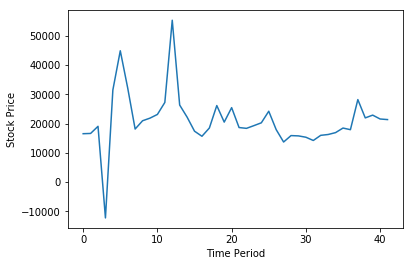

In [46]:
answer=LSTM(txs,1,'WeekNumber_Month_Season_Year' )

In [47]:
len(answer)

2

In [48]:
predict=answer[0]

In [49]:
real=answer[1]

In [52]:
predict[-1]

array([ 21370.06054688], dtype=float32)

In [51]:
real

array([[ 16894.39999997],
       [ 18365.09999997],
       [ 18378.15999997],
       [ 23510.48999996],
       [ 36988.48999994],
       [ 54060.09999991],
       [ 20124.21999997],
       [ 20113.02999997],
       [ 21140.06999996],
       [ 22366.87999996],
       [ 22107.69999996],
       [ 28952.85999995],
       [ 57592.1199999 ],
       [ 34684.20999994],
       [ 16976.18999997],
       [ 16347.59999997],
       [ 17147.43999997],
       [ 18164.19999997],
       [ 18517.78999997],
       [ 16963.54999997],
       [ 16065.48999997],
       [ 17665.99999997],
       [ 17558.81999997],
       [ 16633.40999997],
       [ 15722.81999997],
       [ 17823.36999997],
       [ 16566.17999997],
       [ 16348.05999997],
       [ 15731.17999997],
       [ 16628.30999997],
       [ 16119.91999997],
       [ 17330.69999997],
       [ 16286.39999997],
       [ 16680.23999997],
       [ 18322.36999997],
       [ 19616.21999997],
       [ 19251.49999997],
       [ 18947.80999997],
       [ 219

In [125]:
denormalizedTestPredictY=[item for sublist in predict for item in sublist]

In [126]:
denormalizedTestPredictY

[15798.604,
 14722.048,
 15121.582,
 14954.279,
 17118.977,
 15644.573,
 15849.232,
 15525.247,
 14816.899,
 14112.375,
 14630.68,
 16013.2,
 17937.387,
 19444.676,
 19259.762,
 18787.432,
 24630.928,
 23599.018,
 24115.422,
 18142.271,
 61038.18,
 28532.447,
 15645.645,
 19705.068,
 21329.863,
 30300.719,
 40043.18,
 36211.652,
 22588.805]

In [ ]:
denormalizedTestY=originalSales[train_size+seq_length:]

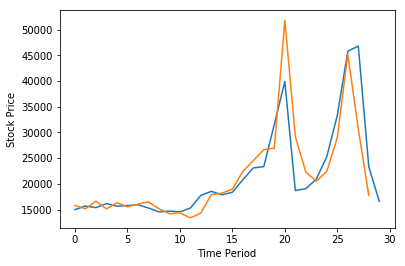

In [3]:
# sales=noOutlierSales(sales)
tempxy=[list(txs['season']),list(txs['year']),list(txs['month']),list(txs['week_number']),sales]
# tempxy=[list(txs['season']),list(txs['day_of_week01']),list(txs['week_number']),sales]
xy=np.array(tempxy).transpose().astype(np.float)
originalxy=np.array(tempxy).transpose().astype(np.float)
xy=minMaxNormalizer(xy)

#data_dim은 y값 도출을 위한 feature 가지수+1(독립변수 가지수 +1(y포함))
data_dim=len(tempxy)
#data_dim크기의 data 한 묶음이 seq_length만큼 input으로 들어가
seq_length=5
#output_dim(=forecastDays)만큼의 다음날 y_data를 예측

output_dim=forecastDay
#hidden_dim은 정말 임의로 설정
hidden_dim=100
#learning rate은 배우는 속도(너무 크지도, 작지도 않게 설정)
learning_rate=0.01
#iterations는 반복 횟수
iterations=1000
x=xy
y=xy[:,[-1]]

#build a series dataset(seq_length에 해당하는 전날 X와 다음 forecastDays에 해당하는 Y)
dataX=[]
dataY=[]
for i in range(0, len(y)-seq_length - forecastDay):
    _x=x[i:i+seq_length]
    _y = y[i + seq_length:i + seq_length + forecastDay]
    _y = np.reshape(_y, (forecastDay))
#     print(_x,"->",_y)
    dataX.append(_x)
    dataY.append(_y)
    train_size = int(len(dataY) * 0.7)
    
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:])
trainY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:])
X=tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y=tf.placeholder(tf.float32, [None, forecastDay])

cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn= None) 
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)
denormalizedTestY=originalSales[train_size+seq_length:]
# denormalizedTestY_original=sales[train_size+seq_length:]
denormalizedTestY_feed=np.array([[i] for i in denormalizedTestY])

targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))
with tf.Session() as sess:
    #초기화
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = minMaxDeNormalizer(sess.run(Y_pred, feed_dict={X: testX}),originalxy)

    # Plot predictions
    plt.plot(denormalizedTestY_feed) #실제 sales 파란색
    plt.plot(test_predict)           #예측 sales 주황색
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()

In [4]:
print(i for i in list(test_predict[-1]    ))

<generator object <genexpr> at 0x000000000CA1B1A8>


In [5]:
list(test_predict[  )

[17721.039]

In [6]:
denormalizedTestPredictY=[item for sublist in test_predict for item in sublist]

In [7]:
rootMeanSquaredError(denormalizedTestY,denormalizedTestPredictY)

IndexError: list index out of range

In [ ]:
len(denormalizedTestPredictY)

In [ ]:
denormalizedTestY